In [1]:
### Importing neccesary dependencies, labels has 0 and 1 output so a classifier is needed
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, log_loss
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
### Importing database from postgresql
import pandas as pd 
import psycopg2 
import pandas.io.sql as sqlio 

connection = psycopg2.connect(user='postgres', password="password", 
host='127.0.0.1',
port='5432', 
database='Startup-Analysis')
sql = "SELECT * FROM startup_alldata"
data = sqlio.read_sql_query(sql,connection)

In [3]:
### Checking data head to see if everything is correct
data.head()

,state_code,year_,vp_gdp,labels,founded_at,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,...,has_angel,has_rounda,has_roundb,has_roundc,has_roundd,avg_participants,is_top500,reached_milestone,founded_first_funding_days_difference,first_last_funding_days_difference
0,CA,2007,1.9,1,2007,2.2493,3.0027,4.6685,6.7041,3,...,1,0,0,0,0,1.0000,0,1,821,275
1,CA,2000,7.7,1,2000,5.1260,9.9973,7.0055,7.0055,9,...,0,0,1,1,1,4.7500,1,1,1871,1778
2,CA,2009,3.2,1,2009,1.0329,1.0329,1.4575,2.2055,5,...,0,1,0,0,0,4.0000,1,1,377,0
3,CA,2002,1.8,1,2002,3.1315,5.3151,6.0027,6.0027,5,...,0,0,1,1,1,3.3333,1,1,1143,797
4,CA,2010,2.0,0,2010,0.0000,1.6685,0.0384,0.0384,2,...,1,0,0,0,0,1.0000,1,1,0,609


Changing Nas with 999 values, we already have 0 value in those columns so if we fill them with 0 we are creating data that might get the model 


confused so we decided to move it up to a standard value so the data is not dropped and it doesn´t create wrong values

In [4]:
### fillong NA with value
data["age_first_milestone_year"] = data["age_first_milestone_year"].fillna(value=999)
data["age_last_milestone_year"] = data["age_last_milestone_year"].fillna(value=999)

From here we separate our target and features, theres going to be different models trying to choose which one is the best for our question

In [5]:
## selecting  features and target, state code and founded at are dropped because they came from the second database and we don´t need it
X = data.drop(["labels", "state_code", "founded_at", "year_"], axis= 1)
y = data["labels"]

In [6]:
#### Create train and transform data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Data is going to be scale to avoid outliers noise 

In [7]:
### Scale the data 
scaler = StandardScaler()

# fit the data
X_scaler = scaler.fit(X_train)

# Transform data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [8]:
#Checking total number of values in train  
y_train.shape

(681,)

The first 2 models we thought where Logistic Regression and Random Forest Classifier, our data had a binary output so classification seemed correct, Logistic Regression was chosen and is the first model because is a more model centric approach, this means to get a better accuracy you need to change the model structure and not the data.

One thing to understand is that Logistic regression is not a 100% binary output, is more of a probability answer combined with a treshold, normally 0.5 and with this combination the labels are assigned. It is a low computer cost and with a fast speed so it´s a good model to see the data and look what you are facing, it is easy to understand.

Some of the disadvantages are that it assumes linearity between the predicted and the predictor variable, it can´t get complex relationships between variables, if the number of observations is less than the number of features it can´t be used.

Assumption
- Independence of errors
- Linearity 
- Absence of multicollinearity
- lack of strong influential outliers

In [9]:
### Create 2 models without PCA

#Start with logistic regression 
##create logistic regression 
model = LogisticRegression(penalty = 'l2',solver="liblinear", random_state=42 , C=1e42)

## fit data to model
model.fit(X_train_scaled, y_train)
## predict data
predictions = model.predict(X_test_scaled)

## print score over training to compare with test to see overfitting
print(model.score(X_train_scaled, y_train))


0.7929515418502202


In [10]:
# print Scores, confusion matrix and report
print(accuracy_score(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))

0.748898678414097
[[ 46  35]
 [ 22 124]]
              precision    recall  f1-score   support

           0       0.68      0.57      0.62        81
           1       0.78      0.85      0.81       146

    accuracy                           0.75       227
   macro avg       0.73      0.71      0.72       227
weighted avg       0.74      0.75      0.74       227



it wasn´t the best model, it had a low f1 score for 0, our focus is to predict failures as well as success so going to try random forest
Random Forest is a ensemble method, it´s created from decision trees that is why the name is forest, trees work in a yes no type of question, and they are easy to understand, although they are prone to overfiting so one way to avoid it is creating a random forest that uses the average answer to decide which is the answer.


This comes with advantages and disadvantages, like we said before it reduces overfiting because each tree is looking at different parts of the dataset, it is made from several weak learners, it has the ability to determine the importance from each variable.


Random forest can be considered a black box, so you really don´t know what is happening but you can change the "hyperparameters" to see different results, altough sklearn has a solution which is Grid Search but it takes a lot of computer power.


Assumptions
- Features should always have values so it can predict accurate results instead of an estimation 
- Trees must have low correlation
- Independence



In [11]:
### Creating random forest instance with 200 estimators and random state fixed so we can replicate it
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)

## fitting the model
rf_model.fit(X_train_scaled, y_train)

## predicting the model and printing accuracy score for training to see overfitting
y_pred = rf_model.predict(X_test_scaled)

print(rf_model.score(X_train_scaled, y_train))

1.0


AUC del set de prueba 0.7202350752579063


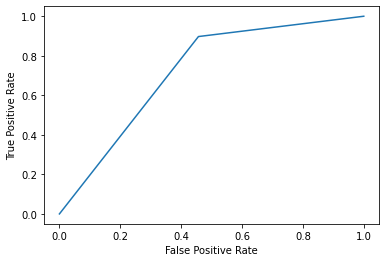

In [12]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
### We are implementing the Roc curve as an aposteriori metric to see the overall accuracy.
### Obtaining false positive rate and true positive rate from our y predictions and the real data (y_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
## plotting the roc curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
### printing accuracy
print("AUC del set de prueba",  auc(fpr, tpr))

In [13]:
### printing different metrics to see model development 
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))


0.7709251101321586
[[ 44  37]
 [ 15 131]]
              precision    recall  f1-score   support

           0       0.75      0.54      0.63        81
           1       0.78      0.90      0.83       146

    accuracy                           0.77       227
   macro avg       0.76      0.72      0.73       227
weighted avg       0.77      0.77      0.76       227



Our model had a score of 1 training and .76 for testing, this is clearly an overfited model, it has good precision for 0 and 1, better than before
and but the recall got worst for 0 and stayed the same for 1, it is a better model than logistic but from this model we are going to take the feature importance to see if we select less features we can get a better model

In [14]:
# We can sort the features by their importance.
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.12671154421248254, 'relationships'),
 (0.09711189619110758, 'age_last_milestone_year'),
 (0.09576172146898532, 'funding_total_usd'),
 (0.07320117893705964, 'age_first_milestone_year'),
 (0.06640861524342859, 'age_last_funding_year'),
 (0.06206750509485298, 'age_first_funding_year'),
 (0.061491416491943306, 'founded_first_funding_days_difference'),
 (0.052669173744221885, 'first_last_funding_days_difference'),
 (0.05169349397340375, 'avg_participants'),
 (0.04793549173689329, 'vp_gdp'),
 (0.04417474181416666, 'milestones'),
 (0.03265144370380809, 'funding_rounds'),
 (0.01973322018776965, 'reached_milestone'),
 (0.018421858555534694, 'is_top500'),
 (0.012625443747617206, 'has_roundc'),
 (0.012223116625509747, 'is_otherstate'),
 (0.011639680164414383, 'has_vc'),
 (0.011216789570301883, 'is_othercategory'),
 (0.01075165417429228, 'has_roundb'),
 (0.009184131253919751, 'is_ca'),
 (0.009116325175794601, 'has_rounda'),
 (0.008705604565185217, 'is_software'),
 (0.007191167987797263, 'is_mo

After looking at the first RF model we saw the importance of each feature and we decided to select the most important features and check for improvements

In [15]:
### Dropping least important features
data2 = data.drop(["is_consulting", "is_ecommerce", "is_advertising", 
"is_enterprise","is_biotech","is_ny", "is_tx", "state_code", "founded_at", "is_ma", 
"is_web", "is_mobile", "is_othercategory"], axis=1)

In [16]:
### Selecting most important features
X2 = data2[["age_last_milestone_year", "relationships", "funding_total_usd", "age_first_milestone_year",
 "age_last_funding_year", "age_first_funding_year", "founded_first_funding_days_difference",
  "first_last_funding_days_difference" ,"avg_participants", "year_", "vp_gdp","milestones","is_top500"]]
y2 = data2["labels"]

We created 2 models again but with the most important features to seek for improvement

In [17]:
### Creating split for training and testing
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=42, stratify=y)

In [18]:
### Creating standard scaler
scaler2 = StandardScaler()
## fitting our standard scaler so it knows the mean and sd
x_scaler2 = scaler2.fit(X_train2)
### transforming training data
X_train_scaled2 = x_scaler2.transform(X_train2)
### transforming test data
X_test_scaled2 = x_scaler2.transform(X_test2)

In [19]:
### Creating second Random forest classifier model
rf_model2 = RandomForestClassifier(n_estimators=200, random_state=42)
### fitting data
rf_model2.fit(X_train_scaled2, y_train)
## predicting data
y_pred2 = rf_model2.predict(X_test_scaled2)

In [20]:
## Printing metrics
print(accuracy_score(y_test2,y_pred2))
print(confusion_matrix(y_test2,y_pred2))
print(classification_report(y_test2, y_pred2))

0.6167400881057269
[[  8  70]
 [ 17 132]]
              precision    recall  f1-score   support

           0       0.32      0.10      0.16        78
           1       0.65      0.89      0.75       149

    accuracy                           0.62       227
   macro avg       0.49      0.49      0.45       227
weighted avg       0.54      0.62      0.55       227



As we can see this was not the answer, it got worse score overall, detecting failure startup is a toin coss so it´s not helpfull at all

AUC del set de prueba 0.4942350714162794


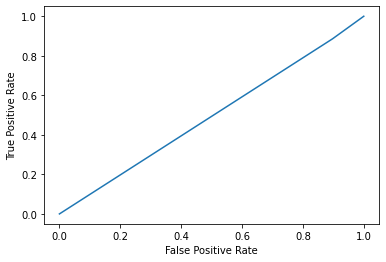

In [21]:
#### Roc curve to see accuracy 
fpr, tpr, _ = roc_curve(y_test2, y_pred2)
### plot roc curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

print("AUC del set de prueba",  auc(fpr, tpr))

The roc curve is a straight line, this is the worst score we could have, so we are ignoring this model

It might be bad with a random forest because we have less features but we might get a higher score with a logistic regression

In [22]:
### Creating model instance
log_reg = LogisticRegression(random_state=42)
## fitting the model
log_reg.fit(X_train_scaled2, y_train2)
##predicting data
pred2 = log_reg.predict(X_test_scaled2)


In [23]:
#### printing model score on training data
print(log_reg.score(X_train_scaled2, y_train2))
print(accuracy_score(y_test2,pred2))
print(classification_report(y_test2,pred2))

0.7591776798825257
0.7312775330396476
              precision    recall  f1-score   support

           0       0.64      0.50      0.56        78
           1       0.77      0.85      0.81       149

    accuracy                           0.73       227
   macro avg       0.70      0.68      0.68       227
weighted avg       0.72      0.73      0.72       227



It got a 75% accuracy for training data and 73% for testing data, is not overfited, for the precision, it did a little bit better than a random event but the recall for 0 is to low, not considering this model 

We are going to try to create a principal components analysis(PCA) to reduce the number of features, PCA is used to reduce the number of predictor variables, the advantages are that it removes correlated features, it improves visualization and it´s easier for the machine to run the algorithm, disadvantage are it becomes less clear and more difficult to interpret, it needs to have standardization and you loose some of the information

To be clear, this is for the data with less features

In [24]:
### pca, the 0.95 defines the treshold for components where the 95% of the variance is explained
pca2 = PCA(0.95)
pca2.fit(X_train_scaled2)
pca2.n_components_

8

With 8 PCA we can try and see if the model gets a better result, this is for the data with less features

In [25]:
## Starting PCA instance
pca = PCA(n_components= 8)
## fitting PCA with data
pca.fit(X_train_scaled2)
#Transform train data with PCA
X_train_scaled_pca = pca.transform(X_train_scaled2)
## Transform test data with PCA
X_test_scaled_pca = pca.transform(X_test_scaled2)

In [26]:
### Creating Random forest instance
rf = RandomForestClassifier(n_estimators=500)
## training model 
rf.fit(X_train_scaled_pca, y_train2)
## Predicting outcomes
y_pred= rf.predict(X_test_scaled_pca)

In [27]:
### Printing metrics to evaluate model
print(accuracy_score(y_test2,y_pred))
print(confusion_matrix(y_test2,y_pred))
print(classification_report(y_test2, y_pred))


0.7136563876651982
[[ 39  39]
 [ 26 123]]
              precision    recall  f1-score   support

           0       0.60      0.50      0.55        78
           1       0.76      0.83      0.79       149

    accuracy                           0.71       227
   macro avg       0.68      0.66      0.67       227
weighted avg       0.70      0.71      0.71       227



Overall accuracy stayed the same, but recall is still low with 53%, we are not going to use Random Forest with PCA.

Now we are going to use the full dataset with all the features

In [28]:
### pca, 25 components explain the 95 variance between the dataset
pca = PCA(0.95)
### fitting X to PCA
pca.fit(X_train_scaled)
## Looking at the number of components that explain 95% of the variance
pca.n_components_

25

With 95% of the variance we had 25 components from 36 variables


In [29]:
## Creating PCA instance with the 95% percent variance from before
pca = PCA(n_components= 25)
### Fitting the dataset with all the features to a pca
pca.fit(X_train_scaled)
### Transforming train data
X_train_scaled_pca = pca.transform(X_train_scaled)
### Transforming test data
X_test_scaled_pca = pca.transform(X_test_scaled)

In [30]:
### Creating Random Forest instance
rf = RandomForestClassifier(n_estimators=500)
## Training the model
rf.fit(X_train_scaled_pca, y_train)
## Predicting
y_pred= rf.predict(X_test_scaled_pca)

In [31]:
# Printing metrics 
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))


0.748898678414097
[[ 40  41]
 [ 16 130]]
              precision    recall  f1-score   support

           0       0.71      0.49      0.58        81
           1       0.76      0.89      0.82       146

    accuracy                           0.75       227
   macro avg       0.74      0.69      0.70       227
weighted avg       0.74      0.75      0.74       227



Accuracy stayed the same again, but recall for 0 is still low with only 56% and precision of 68% so the negative label is not well represented, we need a balanced model to detect which startups are going to fail

with PCA we only used Random Forest, with less multicollinearity from PCA we wish to see a better model

In [32]:
#Logistic Regression instance
log_model = LogisticRegression(random_state=42)

In [33]:
## Training model
log_model.fit(X_train_scaled_pca, y_train)
# Predicting
predictions = log_model.predict(X_test_scaled_pca)

In [34]:
# Printing metrics
print(accuracy_score(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))


0.7400881057268722
[[ 42  39]
 [ 20 126]]
              precision    recall  f1-score   support

           0       0.68      0.52      0.59        81
           1       0.76      0.86      0.81       146

    accuracy                           0.74       227
   macro avg       0.72      0.69      0.70       227
weighted avg       0.73      0.74      0.73       227



It got worse metrics than the first logistic regression, recall got a lower score so this is not the correct way to go

We didn´t get any better accuracy so we are going to step it up a little bit creating a neural network and look at the results, the activation functions were selected for what we need and at the end we needed a sigmoid activation to get a binary classifier

Neural network (NN) tries to replicate the brain cells and function, they are composed of nodes and layers and contain an input and output. Each node needs to be connected with another node and if the output of the first node is above from the threshold the next node will be activated, otherwise no data is passed. This technology is the base of deep learning and it´s a really powerful and reliable algorithm

Basic rules
- Artificial neurons or nodes are arranged in layers (known as Hidden layers, input or output layers)
- Neurons with the same layer do not interact between them
- All hidden layers at the same level should have the same activation function
- Every interconnected neural network has it´s own weight and bias

In [36]:
## Creating model instance
nn_model = tf.keras.models.Sequential()

In [37]:
## Adding layers to our model 
nn_model.add(tf.keras.layers.Dense(units=80, activation="relu", input_dim=35))
nn_model.add(tf.keras.layers.Dense(units=50, activation="relu"))
nn_model.add(tf.keras.layers.Dense(units=30, activation="tanh"))
nn_model.add(tf.keras.layers.Dense(units=20, activation="relu"))
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

In [38]:
# Compiling model to set loss and optimizer
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
## fit the model
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=500)

Epoch 1/500
22/22 [==============================] - 1s 3ms/step - loss: 0.6721 - accuracy: 0.5977
Epoch 2/500
22/22 [==============================] - 0s 4ms/step - loss: 0.5678 - accuracy: 0.7210
Epoch 3/500
22/22 [==============================] - 0s 3ms/step - loss: 0.5053 - accuracy: 0.7651
Epoch 4/500
22/22 [==============================] - 0s 3ms/step - loss: 0.4682 - accuracy: 0.8076
Epoch 5/500
22/22 [==============================] - 0s 3ms/step - loss: 0.4427 - accuracy: 0.8062
Epoch 6/500
22/22 [==============================] - 0s 2ms/step - loss: 0.4191 - accuracy: 0.8297
Epoch 7/500
22/22 [==============================] - 0s 2ms/step - loss: 0.3998 - accuracy: 0.8370
Epoch 8/500
22/22 [==============================] - 0s 3ms/step - loss: 0.3677 - accuracy: 0.8517
Epoch 9/500
22/22 [==============================] - 0s 3ms/step - loss: 0.3493 - accuracy: 0.8590
Epoch 10/500
22/22 [==============================] - 0s 3ms/step - loss: 0.3228 - accuracy: 0.8752
Epoch 11/

In [39]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 3.1830 - accuracy: 0.7048 - 267ms/epoch - 33ms/step
Loss: 3.1830270290374756, Accuracy: 0.7048457860946655


The model accuracy got to 1.0 at the first 100 epochs, it is learning all the answers but still going to change activation functions to see results
got a 70% accuracy, maybe adding some layers or changing activation functions we can get a better result

In [40]:
## Creating second model instance
nn_model2 = tf.keras.models.Sequential()

In [41]:
## Adding layers
nn_model2.add(tf.keras.layers.Dense(units=80, activation="relu", input_dim=35))
nn_model2.add(tf.keras.layers.Dense(units=50, activation="relu"))
nn_model2.add(tf.keras.layers.Dense(units=30, activation="sigmoid"))
nn_model2.add(tf.keras.layers.Dense(units=25, activation="tanh"))
nn_model2.add(tf.keras.layers.Dense(units=20, activation="tanh"))
nn_model2.add(tf.keras.layers.Dense(units=10, activation="relu"))
nn_model2.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

In [42]:
## Compiling model
nn_model2.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
#fitting model
fit_model = nn_model2.fit(X_train_scaled, y_train, epochs=500)

Epoch 1/500
22/22 [==============================] - 2s 3ms/step - loss: 0.6535 - accuracy: 0.6314
Epoch 2/500
22/22 [==============================] - 0s 3ms/step - loss: 0.5914 - accuracy: 0.6725
Epoch 3/500
22/22 [==============================] - 0s 3ms/step - loss: 0.5220 - accuracy: 0.7768
Epoch 4/500
22/22 [==============================] - 0s 3ms/step - loss: 0.4874 - accuracy: 0.7797
Epoch 5/500
22/22 [==============================] - 0s 3ms/step - loss: 0.4569 - accuracy: 0.8032
Epoch 6/500
22/22 [==============================] - 0s 3ms/step - loss: 0.4378 - accuracy: 0.8076
Epoch 7/500
22/22 [==============================] - 0s 3ms/step - loss: 0.4189 - accuracy: 0.8179
Epoch 8/500
22/22 [==============================] - 0s 2ms/step - loss: 0.3922 - accuracy: 0.8429
Epoch 9/500
22/22 [==============================] - 0s 2ms/step - loss: 0.3682 - accuracy: 0.8399
Epoch 10/500
22/22 [==============================] - 0s 2ms/step - loss: 0.3442 - accuracy: 0.8649
Epoch 11/

In [43]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model2.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 3.0632 - accuracy: 0.7269 - 191ms/epoch - 24ms/step
Loss: 3.063189744949341, Accuracy: 0.7268722653388977


Accuracy stayed the same, and the model learned the answers in the first 100 epochs so it is overfitting, going to try again

In [44]:
## Creating third model instance
nn_model3 = tf.keras.models.Sequential()

In [45]:
### Adding layers
nn_model3.add(tf.keras.layers.Dense(units=80, activation="relu", input_dim=35))
nn_model3.add(tf.keras.layers.Dense(units=50, activation="relu"))
nn_model3.add(tf.keras.layers.Dense(units=30, activation="hard_sigmoid"))
nn_model3.add(tf.keras.layers.Dense(units=20, activation="tanh"))
nn_model3.add(tf.keras.layers.Dense(units=10, activation="relu"))
nn_model3.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

In [46]:
### Compiling model
nn_model3.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
## fitting model
fit_model = nn_model3.fit(X_train_scaled, y_train, epochs=500)

Epoch 1/500
22/22 [==============================] - 2s 3ms/step - loss: 0.6603 - accuracy: 0.6211
Epoch 2/500
22/22 [==============================] - 0s 2ms/step - loss: 0.5927 - accuracy: 0.6667
Epoch 3/500
22/22 [==============================] - 0s 2ms/step - loss: 0.5469 - accuracy: 0.7342
Epoch 4/500
22/22 [==============================] - 0s 2ms/step - loss: 0.5216 - accuracy: 0.7915
Epoch 5/500
22/22 [==============================] - 0s 2ms/step - loss: 0.5021 - accuracy: 0.7930
Epoch 6/500
22/22 [==============================] - 0s 2ms/step - loss: 0.4840 - accuracy: 0.8076
Epoch 7/500
22/22 [==============================] - 0s 2ms/step - loss: 0.4689 - accuracy: 0.8076
Epoch 8/500
22/22 [==============================] - 0s 2ms/step - loss: 0.4528 - accuracy: 0.8150
Epoch 9/500
22/22 [==============================] - 0s 2ms/step - loss: 0.4332 - accuracy: 0.8267
Epoch 10/500
22/22 [==============================] - 0s 2ms/step - loss: 0.4137 - accuracy: 0.8311
Epoch 11/

In [47]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model3.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 4.7360 - accuracy: 0.6828 - 263ms/epoch - 33ms/step
Loss: 4.736026287078857, Accuracy: 0.6828193664550781


Same problem as the last 2, it appears that Neural Network is not the way to go

In [48]:
## Creating fourth model instance
nn_model4 = tf.keras.models.Sequential()

In [49]:
## Adding layers
nn_model4.add(tf.keras.layers.Dense(units=80, activation="relu", input_dim=35))
nn_model4.add(tf.keras.layers.Dense(units=50, activation="tanh"))
nn_model4.add(tf.keras.layers.Dense(units=40, activation="relu"))
nn_model4.add(tf.keras.layers.Dense(units=30, activation="relu"))
nn_model4.add(tf.keras.layers.Dense(units=15, activation="tanh"))
nn_model4.add(tf.keras.layers.Dense(units=5, activation="relu"))
nn_model4.add(tf.keras.layers.Dense(units=3, activation="tanh"))
nn_model4.add(tf.keras.layers.Dense(units=2, activation="relu"))
nn_model4.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

In [50]:
## Compiling model
nn_model4.compile(loss="BinaryCrossentropy", optimizer="adam", metrics=["accuracy"])
## fitting model
fit_model = nn_model4.fit(X_train_scaled, y_train, epochs=500)

Epoch 1/500
22/22 [==============================] - 1s 8ms/step - loss: 0.6781 - accuracy: 0.7048
Epoch 2/500
22/22 [==============================] - 0s 2ms/step - loss: 0.6134 - accuracy: 0.7386
Epoch 3/500
22/22 [==============================] - 0s 3ms/step - loss: 0.5723 - accuracy: 0.7636
Epoch 4/500
22/22 [==============================] - 0s 3ms/step - loss: 0.5501 - accuracy: 0.7841
Epoch 5/500
22/22 [==============================] - 0s 2ms/step - loss: 0.5338 - accuracy: 0.8032
Epoch 6/500
22/22 [==============================] - 0s 2ms/step - loss: 0.5189 - accuracy: 0.8120
Epoch 7/500
22/22 [==============================] - 0s 3ms/step - loss: 0.5102 - accuracy: 0.8253
Epoch 8/500
22/22 [==============================] - 0s 3ms/step - loss: 0.5055 - accuracy: 0.8164
Epoch 9/500
22/22 [==============================] - 0s 3ms/step - loss: 0.4941 - accuracy: 0.8223
Epoch 10/500
22/22 [==============================] - 0s 3ms/step - loss: 0.4783 - accuracy: 0.8443
Epoch 11/

In [51]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model4.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 3.2799 - accuracy: 0.6916 - 263ms/epoch - 33ms/step
Loss: 3.2799313068389893, Accuracy: 0.691629946231842


Although it didn´t learn the answers in the first 100 epochs it didn´t get a better score

4 different NN didn´t get pass 75% accuracy so we are going to go back to rf and logistic regression

The first random forest looks like the best option, the NN is overffiting so we are not going to use it like that, looking at the labels it 
appears to need a resampling so we are going to use a Random Undersampling, Random Oversampling and SMOTEEN to see if any of this help

In [52]:
## Importing dependencies 
from imblearn.under_sampling import RandomUnderSampler
## Creating Random undersampler 
ros = RandomUnderSampler(random_state=42)
### Transform the data to undersampling
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

In [53]:
## initializing random forest
rf_ = RandomForestClassifier(n_estimators= 1000, max_depth= 15, 
min_samples_split = 0.34253241,   min_samples_leaf= 0.041234523, class_weight = {0:1,1:1}, random_state=0)

In [54]:
## fitting and predicting
rf_.fit(X_resampled, y_resampled)
y_pred = rf_.predict(X_test_scaled)

In [55]:
### printing metrics
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))


0.7224669603524229
[[ 55  26]
 [ 37 109]]
              precision    recall  f1-score   support

           0       0.60      0.68      0.64        81
           1       0.81      0.75      0.78       146

    accuracy                           0.72       227
   macro avg       0.70      0.71      0.71       227
weighted avg       0.73      0.72      0.73       227



The precission for 0 got worse, recall got almost 70% but we sacrificed recall for 1 reducing it to 75%, we are going to try with Logistic Regression to see how it does

In [56]:
### Creating logistic regression instance
log_r = LogisticRegression(random_state=42)
## Fitting and training data 
log_r.fit(X_resampled, y_resampled)
y_pred = rf_.predict(X_test_scaled)

In [57]:
### printing metrics
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

0.7224669603524229
[[ 55  26]
 [ 37 109]]
              precision    recall  f1-score   support

           0       0.60      0.68      0.64        81
           1       0.81      0.75      0.78       146

    accuracy                           0.72       227
   macro avg       0.70      0.71      0.71       227
weighted avg       0.73      0.72      0.73       227



with a 64% f1 score for 0 it is not to bad, but still recall for 1 get´s lower so we are going to try different approach 

In [58]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from imblearn.combine import SMOTEENN

In [59]:
## Creating Random Over Sampler Instance
ros = RandomOverSampler(random_state=0)
# Resampling data
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

In [60]:
### Creating Random Forest Instance
rf_over = RandomForestClassifier(n_estimators=200)
## training the model
rf_over.fit(X_resampled, y_resampled)
## predicting
y_pred = rf_over.predict(X_test_scaled)

In [61]:
(((60+75)/2) + ((84+72)/2))/2

72.75

In [62]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.65      0.53      0.84      0.59      0.67      0.43        81
          1       0.76      0.84      0.53      0.80      0.67      0.46       146

avg / total       0.72      0.73      0.64      0.72      0.67      0.45       227



It did better in the overall accuracy, but still the recall is low, so we are going to try Logistic Regression 

In [63]:
## Creating instance
lg_over = LogisticRegression(random_state=42)
## Training the model 
lg_over.fit(X_resampled, y_resampled)
## predicting the model
y_pred = lg_over.predict(X_test_scaled)

In [67]:
y_proba = lg_over.predict_proba(X_test_scaled)

In [70]:
y_proba=y_proba[:,1]

In [73]:
print(classification_report(y_test, y_pred))
print(log_loss(y_test, lg_over.predict_proba(X_test_scaled)))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.75      0.66        81
           1       0.84      0.71      0.77       146

    accuracy                           0.73       227
   macro avg       0.72      0.73      0.72       227
weighted avg       0.75      0.73      0.73       227

0.5546270100161605
[[ 61  20]
 [ 42 104]]


AUC del set de prueba 0.7920683240317944


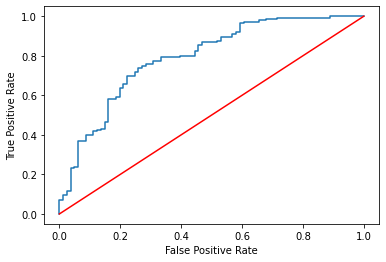

In [ ]:
y_proba = lg_over.predict_proba(X_test_scaled)
fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.plot([0,1],[0,1], c='red')
print("AUC del set de prueba",  auc(fpr, tpr))

Logistic Regression with Oversampling has a good score overall, somewhat balanced and with a good AUC score with almost 80% although the log loss is a little low with a 0.55, taking in consideration that the dataset it´s a little bit unbalanced, we can still consider it a good model, we will try different options to see what we can get


Going to try different approaches with SMOTEEN so first we are going to create a function and try different classifiers, if one of the classifiers gives us a good score we are going to look deep into it

In [83]:
## create SMOTEEN function for random forest and variations 

def rf_model(X,y,model):
    ## Create instance of model
    model = model(n_estimators=200, random_state=42)
    ### create split data
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    ## create SMOTEEN instance
    smote = SMOTEENN(random_state=42)
    ### Resample X and Y
    X_resampled, y_resampled = smote.fit_resample(X_train,y_train)
    ## Train the model
    model.fit(X_resampled, y_resampled)
    # Predict the model
    predictions = model.predict(X_test)
    ### Create the report
    report= classification_report_imbalanced(y_test,predictions)
    ## Create the accuracy score
    accuracy = accuracy_score(y_test,predictions)
    return print(report), print(f'the accuracy for {model} is {accuracy}')

In [84]:

rf_model(X,y, RandomForestClassifier)

              precision    recall  f1-score   support

           0       0.56      0.55      0.55        78
           1       0.77      0.77      0.77       149

    accuracy                           0.70       227
   macro avg       0.66      0.66      0.66       227
weighted avg       0.70      0.70      0.70       227

the accuracy for RandomForestClassifier(n_estimators=200, random_state=42) is 0.6960352422907489


(None, None)

Score of 70%, overall precision and recall for 0 is low, not taking this model into consideration

In [85]:
rf_model(X,y,EasyEnsembleClassifier)

              precision    recall  f1-score   support

           0       0.54      0.61      0.57        71
           1       0.81      0.76      0.79       156

    accuracy                           0.71       227
   macro avg       0.67      0.68      0.68       227
weighted avg       0.72      0.71      0.72       227

the accuracy for EasyEnsembleClassifier(n_estimators=200, random_state=42) is 0.7136563876651982


(None, None)

Got almost the same accuracy but with a little bit different recall for 0, still is to low, we are going to go other ways

In [86]:
rf_model(X,y, BalancedRandomForestClassifier)

              precision    recall  f1-score   support

           0       0.69      0.53      0.60        81
           1       0.77      0.87      0.82       146

    accuracy                           0.75       227
   macro avg       0.73      0.70      0.71       227
weighted avg       0.74      0.75      0.74       227

the accuracy for BalancedRandomForestClassifier(n_estimators=200, random_state=42) is 0.748898678414097


(None, None)

It got better results for 1 and precision for 0, the recall got worst

In [87]:
rf_model(X,y, RandomForestClassifier)

              precision    recall  f1-score   support

           0       0.63      0.46      0.53        85
           1       0.72      0.84      0.78       142

    accuracy                           0.70       227
   macro avg       0.68      0.65      0.65       227
weighted avg       0.69      0.70      0.68       227

the accuracy for RandomForestClassifier(n_estimators=200, random_state=42) is 0.6960352422907489


(None, None)

It didn´t help a lot, it stayed the same as the balanced random forest with the exception of recall for 0, it got even worst

The different methodologies didn´t help to get a better score


For this part we went to R and created a linear model to see which variables where significant (p>0.05) and decided to stay with them

In [88]:
### Selecting features
data3 = data[["labels","first_last_funding_days_difference", "reached_milestone","is_top500", "has_roundb", "milestones", "funding_rounds", "relationships"]]

In [89]:
### Looking at data
data3.head()

,labels,first_last_funding_days_difference,reached_milestone,is_top500,has_roundb,milestones,funding_rounds,relationships
0,1,275,1,0,0,3,3,3
1,1,1778,1,1,1,1,4,9
2,1,0,1,1,0,2,1,5
3,1,797,1,1,1,1,3,5
4,0,609,1,1,0,1,2,2
...,...,...,...,...,...,...,...,...
903,1,1142,1,1,0,2,5,9
904,1,0,1,1,0,2,1,9
905,0,0,1,1,0,1,1,5
906,1,757,1,1,1,2,2,12


In [90]:
### Selecting features to predict
X3 = data3.drop("labels", axis=1)
### Selecting labels
y3 = data3["labels"]

In [91]:
## Splitting data
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3)

In [101]:
## Standarizing data
st_scaler = StandardScaler()
## Fitting data to scaler
X3_scaler = st_scaler.fit(X3_train)
## Scaling train data
X3_train_scaled = X3_scaler.transform(X3_train)
# scaling test data
X3_test_scaled = X3_scaler.transform(X3_test)

In [97]:
# Creating instance for logistic regresion
lg_reg = LogisticRegression(random_state=42)
### Training the model
lg_reg.fit(X3_train_scaled, y3_train)
## predicting data
pred3 = lg_reg.predict(X3_test_scaled)

AUC del set de prueba 0.780995040793473


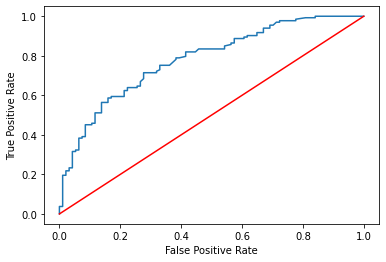

In [102]:
### Predicting proba
y_proba = lg_reg.predict_proba(X3_test_scaled)
### False positive rate, positive rate and treshold
fpr, tpr, _ = roc_curve(y3_test, y_proba[:,1])
### Creating Roc Curve plot
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
## adding no skill model
plt.plot([0,1],[0,1], c='red')
### printing auc value
print("AUC del set de prueba",  auc(fpr, tpr))

In [103]:
## Printing classification report
print(classification_report(y3_test, pred3))

              precision    recall  f1-score   support

           0       0.71      0.43      0.53        94
           1       0.68      0.88      0.77       133

    accuracy                           0.69       227
   macro avg       0.70      0.65      0.65       227
weighted avg       0.70      0.69      0.67       227



Although the AUC score is good, recall score is low 

Low score for 0 f1, not doing a good job classifying 

In [126]:
### Random forest instance
Rf = RandomForestClassifier(n_estimators=200)
##Training the model
Rf.fit(X3_train_scaled, y3_train)
### Predicting with test data
y_pred3 = Rf.predict(X3_test_scaled)
### Accuracy score metric
accuracy_score(y3_test,y_pred3)
print(classification_report(y3_test,y_pred3))

              precision    recall  f1-score   support

           0       0.73      0.48      0.58        94
           1       0.70      0.87      0.78       133

    accuracy                           0.71       227
   macro avg       0.71      0.68      0.68       227
weighted avg       0.71      0.71      0.70       227



The accuracy score is low, and then again, recall for 0 is low, the other scores are a better but this is not what we are looking for

AUC del set de prueba 0.7487193075428369


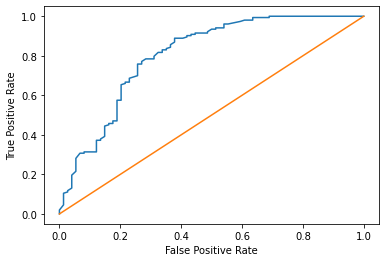

In [ ]:

y3_proba = Rf.predict_proba(X3_test_scaled)
fpr, tpr, _ = roc_curve(y3_test, y3_proba[:,1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

fpr, tpr, thresholds = roc_curve(y3_test,y_pred3, pos_label=1)
print("AUC del set de prueba",  auc(fpr, tpr))
plt.plot([0,1], [0,1])

The features with significance didn´t got a better result so we are going to use all the features and try some models again for some hyperparameter tunning

In [ ]:
X2 = data2.drop("labels", axis=1)
y2 = data2["labels"]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2)

In [ ]:
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf. fit(X2_train, y2_train)
pred2 = clf.predict(X2_test)
accuracy_score(y2_test, pred2)
print(classification_report(y2_test,pred2))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69        75
           1       0.84      0.87      0.85       152

    accuracy                           0.80       227
   macro avg       0.78      0.77      0.77       227
weighted avg       0.80      0.80      0.80       227



1 label always does somewhat good, the focus is in the 0, we always get a high precision but we need some better recall

Going to try other ensemble method by boosting instead of bagging, comparing results to decide which way to go

Both bagging and boosting have the same basic idea, use a lot of weak learners to reach a final result, bagging uses a system where each tree needs to be better than the last one to have a "vote" in the decision and after that the one with more results is chosen, boosting learns from each tree and tries to perform better 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
   classifier = GradientBoostingClassifier(n_estimators=20,
   learning_rate=learning_rate,
   max_features=5,
   max_depth=3,
   random_state=0)
   classifier.fit(X2_train, y2_train)
   print(f"Learning rate : {learning_rate}")
   print("Training score: {0:.3f}".format(classifier.score(X2_train, y2_train)))
   print("Testing score: {0:.3f}".format(classifier.score(X2_test,y2_test)))
   print("------------------------------")

   
   


Learning rate : 0.05
Training score: 0.805
Testing score: 0.797
------------------------------
Learning rate : 0.1
Training score: 0.822
Testing score: 0.806
------------------------------
Learning rate : 0.25
Training score: 0.869
Testing score: 0.815
------------------------------
Learning rate : 0.5
Training score: 0.913
Testing score: 0.789
------------------------------
Learning rate : 0.75
Training score: 0.928
Testing score: 0.758
------------------------------
Learning rate : 1
Training score: 0.943
Testing score: 0.731
------------------------------


At a higher learning rate the training score goes up but the testing score goes down, the model is learning the answer and it cannot do well with new data so we are using smaller learning rates

In [ ]:
rf_2 = RandomForestClassifier(n_estimators=1500, max_depth=8, min_samples_leaf=3, class_weight = {0:0.86,1:0.42},random_state=0)
rf_2.fit(X_train_scaled, y_train)
pred = rf_2.predict(X_test_scaled)
print(classification_report(y_test,pred))
print(accuracy_score(y_test,pred))
print(confusion_matrix(y_test,pred))


              precision    recall  f1-score   support

           0       0.69      0.62      0.65        81
           1       0.80      0.85      0.82       146

    accuracy                           0.77       227
   macro avg       0.75      0.73      0.74       227
weighted avg       0.76      0.77      0.76       227

0.7665198237885462
[[ 50  31]
 [ 22 124]]


We are doing a grid search with f1 as metric to see the results for different weights between 1 and 0, we are looking at the mean test score and splot 0 and 1 to check the highest score and apply them into our model

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np

In [ ]:
### Rnadom Forest instance
rf_3 = RandomForestClassifier(n_estimators=200)
weights = np.linspace(0.0,0.99,200)

# set the weights
param_grid= {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

## fitting in grid search 
Gridsearch = GridSearchCV(estimator= rf_3,
                            param_grid= param_grid,
                            cv=StratifiedKFold(),
                            scoring='accuracy').fit(X_train_scaled, y_train)

In [ ]:
##3 Looking at gird search to see different weights
Gridsearch

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_estimators=200),
             param_grid={'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.004974874371859297,
                                           1: 0.9950251256281407},
                                          {0: 0.009949748743718593,
                                           1: 0.9900502512562814},
                                          {0: 0.014924623115577889,
                                           1: 0.9850753768844221},
                                          {0: 0.019899497487437186,
                                           1: 0.980100502512562...
                                           1: 0.8905527638190954},
                                          {0: 0.11442211055276383,
                                           1: 0.8855778894472361},
                                          {0: 0.1193969

c:\Users\OMEN\anaconda3\envs\mlenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='weight', ylabel='score'>

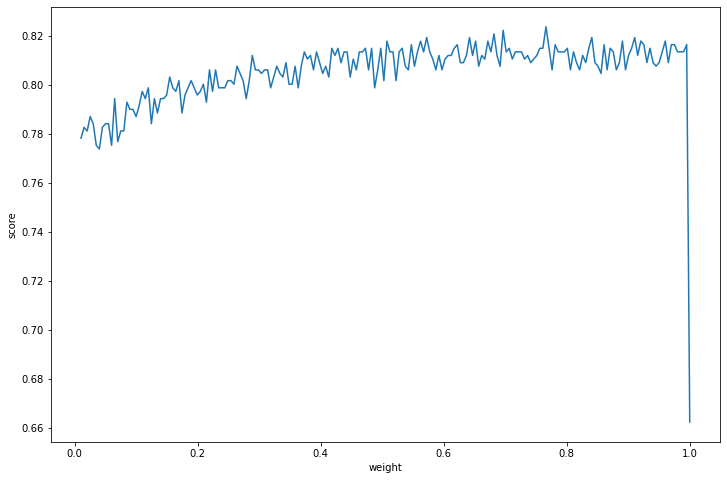

In [ ]:
### Looking at mean test score
plt.figure(figsize= (12,8))
weigh_data = pd.DataFrame({'score': Gridsearch.cv_results_['mean_test_score'], 'weight': (1-weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])


c:\Users\OMEN\anaconda3\envs\mlenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='weight', ylabel='score'>

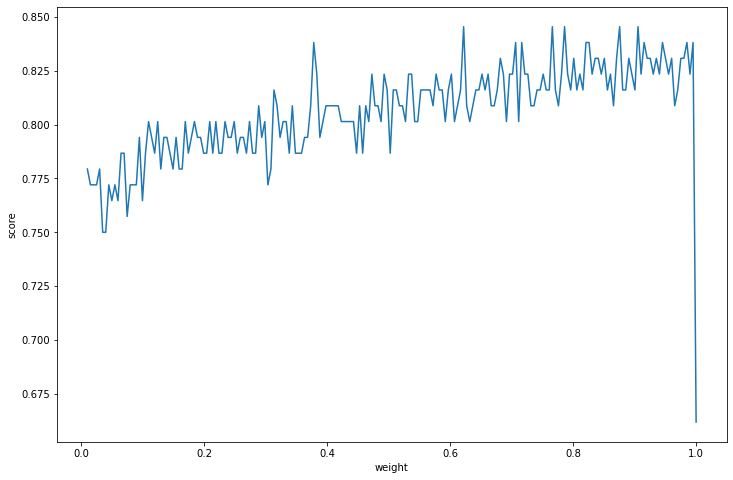

In [ ]:
#For 1 the best score is from 0.8 to 1
plt.figure(figsize= (12,8))
weigh_data = pd.DataFrame({'score': Gridsearch.cv_results_['split1_test_score'], 'weight': (1-weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])


The first score is both of 0 and 1 f1 scores in average, we cans ee that the best score is never going to be more than .82 if we only change the class_weight, but this is only with the average, still going to play a little bit moving class_weight to see if I can get a better recall

In [124]:
## Model instance
rf_mod = RandomForestClassifier(n_estimators=200, class_weight = {0:0.91, 1:0.9}, random_state=42)
## training model
rf_mod.fit(X_train_scaled, y_train)
### Predicting data
y_pred = rf_mod.predict(X_test_scaled)
##Training score
print(rf_mod.score(X_train_scaled, y_train))
##m testing score
print(accuracy_score( y_test, y_pred))
print(classification_report(y_test, y_pred))

1.0
0.6211453744493393
              precision    recall  f1-score   support

           0       0.33      0.10      0.16        78
           1       0.66      0.89      0.76       149

    accuracy                           0.62       227
   macro avg       0.49      0.50      0.46       227
weighted avg       0.54      0.62      0.55       227



The model is overfitted with a perfect score in training and less than 80% on testing, the model doesn´t do well with new data and got a really low score for f1

Using gridsearch to select better hyperparameters for gradient boosting

In [ ]:

#creating Scoring parameter: 
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),'recall':make_scorer(recall_score)}

# A sample parameter

parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }
#passing the scoring function in the GridSearchCV
clf = GridSearchCV(GradientBoostingClassifier(), parameters,scoring=scoring,refit=False,cv=2, n_jobs=-1)


In [ ]:
clf.fit(X_train_scaled, y_train)
#converting the clf.cv_results to dataframe
df=pd.DataFrame.from_dict(clf.cv_results_)
#here Possible inputs for cross validation is cv=2, there two split split0 and split1
df[['split0_test_accuracy','split1_test_accuracy','split0_test_precision','split1_test_precision','split0_test_recall','split1_test_recall']]

,split0_test_accuracy,split1_test_accuracy,split0_test_precision,split1_test_precision,split0_test_recall,split1_test_recall
0,0.662757,0.661765,0.662757,0.661765,1.0,1.0
1,0.662757,0.661765,0.662757,0.661765,1.0,1.0
2,0.662757,0.661765,0.662757,0.661765,1.0,1.0
3,0.662757,0.661765,0.662757,0.661765,1.0,1.0
4,0.662757,0.661765,0.662757,0.661765,1.0,1.0
...,...,...,...,...,...,...
84667,0.662757,0.661765,0.662757,0.661765,1.0,1.0
84668,0.662757,0.661765,0.662757,0.661765,1.0,1.0
84669,0.662757,0.661765,0.662757,0.661765,1.0,1.0
84670,0.662757,0.661765,0.662757,0.661765,1.0,1.0


In [ ]:
#find the best parameter based on the accuracy_score
#taking the average of the accuracy_score
df['accuracy_score']=(df['split0_test_accuracy']+df['split1_test_accuracy'])/2

df.loc[df['accuracy_score'].idxmax()]['params']

{'criterion': 'friedman_mse',
 'learning_rate': 0.15,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.24545454545454548,
 'n_estimators': 10,
 'subsample': 0.95}

We are going to use the best parameters found in Grid search, the first time it was ran the n_estimators list was [10, 50, 100, 150, 200] but it took 5 hours to run, the parameters did´t change even though n_estimators did and the right numbers of estimators selected by the grid search was 200

In [ ]:
classifier = GradientBoostingClassifier(n_estimators=200,
   learning_rate=0.15,
   loss =  'deviance',
   max_features = "sqrt",
   min_samples_leaf = 0.1,
   min_samples_split = 0.24545454545454548,
   subsample= 0.95,
   max_depth=5,
   random_state=0)

In [ ]:
classifier.fit(X_train_scaled, y_train)
pred = classifier.predict(X_test_scaled)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.64      0.53      0.58        81
           1       0.76      0.84      0.80       146

    accuracy                           0.73       227
   macro avg       0.70      0.68      0.69       227
weighted avg       0.72      0.73      0.72       227



The score we got is lower but we think it might still be a good idea to try with gradient boosting 

In [ ]:
def plot_sklearn_roc_curve(y_real, y_pred):
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')

0.786741078978522


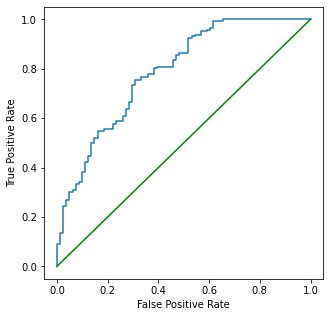

In [ ]:
from sklearn.metrics import  roc_auc_score
y_pred_proba = classifier.predict_proba(X_test_scaled)

auc = roc_auc_score(y_test, y_pred_proba[::,1])
print(auc)
plot_sklearn_roc_curve(y_test, y_pred_proba[:,1])

In [122]:
classifier = GradientBoostingClassifier(n_estimators=200,
   learning_rate=0.05,
   max_features=8,
   min_samples_leaf= 0.1,
   loss= 'deviance',
   max_depth=3,
   subsample = 0.95,
   random_state=0)

classifier.fit(X_train_scaled, y_train)
print("Accuracy score (training): {0:.2f}".format(
classifier.score(X_train_scaled, y_train)))
print("Accuracy score (validation): {0:.2f}".format(
classifier.score(X_test_scaled, y_test)))
y_pred = classifier.predict(X_test_scaled)

Accuracy score (training): 0.73
Accuracy score (validation): 0.63


AUC del set de prueba 0.806527989176391


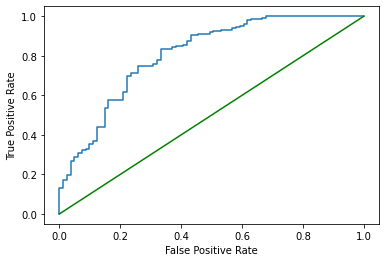

In [ ]:
y_proba = classifier.predict_proba(X_test_scaled)
fpr, tpr, tresh = roc_curve(y_test, y_proba[:,1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.plot([0,1],[0,1], c='g')


print("AUC del set de prueba",  auc(fpr, tpr))

Looking at model Roc to see if we can move the treshold

In [ ]:
fp_tr = pd.DataFrame({'FR':fpr, 'TPR':tpr, 'thresholds':tresh})

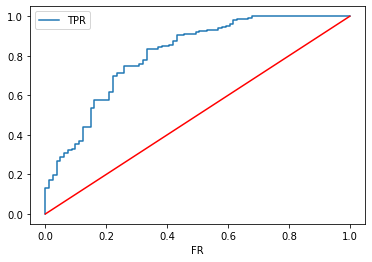

In [ ]:
fp_tr.plot(x= 'FR', y= 'TPR')
plt.plot([0,1], [0,1], c="r")